<a href="https://colab.research.google.com/github/dinesh-umkc/kdm/blob/main/ICP13_GCN_Node_Clasification_Stelargraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objective
* Perform Node claasification using StelarGraph
* Load Cora citation data

In [2]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 4.8 MB/s 


#Load libraries

In [3]:

import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

#Load data

In [4]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [5]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [6]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


#Split data

In [7]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

#Converting to numeric arrays with one hot vector

In [8]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

#Creating GCN Layer

In [9]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [10]:
#
train_gen = generator.flow(train_subjects.index, train_targets)

In [11]:
#Create two layers with 16 units each
# user relu as sctivation function
# Dropout 50%
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)


In [12]:
#Input and output tensor
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [13]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

#Training and evaluating

In [14]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
#Validation Set
val_gen = generator.flow(val_subjects.index, val_targets)

In [17]:
#Early stopping if validation accuracy stops
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [18]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 2s - loss: 1.9438 - acc: 0.0929 - val_loss: 1.9002 - val_acc: 0.3160 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.8816 - acc: 0.3571 - val_loss: 1.8359 - val_acc: 0.3100 - 135ms/epoch - 135ms/step
Epoch 3/200
1/1 - 0s - loss: 1.7966 - acc: 0.3786 - val_loss: 1.7639 - val_acc: 0.3080 - 137ms/epoch - 137ms/step
Epoch 4/200
1/1 - 0s - loss: 1.6997 - acc: 0.3929 - val_loss: 1.6993 - val_acc: 0.3060 - 130ms/epoch - 130ms/step
Epoch 5/200
1/1 - 0s - loss: 1.6142 - acc: 0.3643 - val_loss: 1.6446 - val_acc: 0.3060 - 142ms/epoch - 142ms/step
Epoch 6/200
1/1 - 0s - loss: 1.5177 - acc: 0.3714 - val_loss: 1.5856 - val_acc: 0.3220 - 126ms/epoch - 126ms/step
Epoch 7/200
1/1 - 0s - loss: 1.4006 - acc: 0.4286 - val_loss: 1.5145 - val_acc: 0.3800 - 141ms/epoch - 141ms/step
Epoch 8/200
1/1 - 0s - loss: 1.3537 - acc: 0.4786 - val_loss: 1.4342 - val_acc: 0.4660 - 133ms/epoch - 133ms/step
Epoch 9/200
1/1 - 0s - loss: 1.2289 - acc: 0.5214 - val_loss: 1.3517 - val_acc: 0.5400 - 127ms

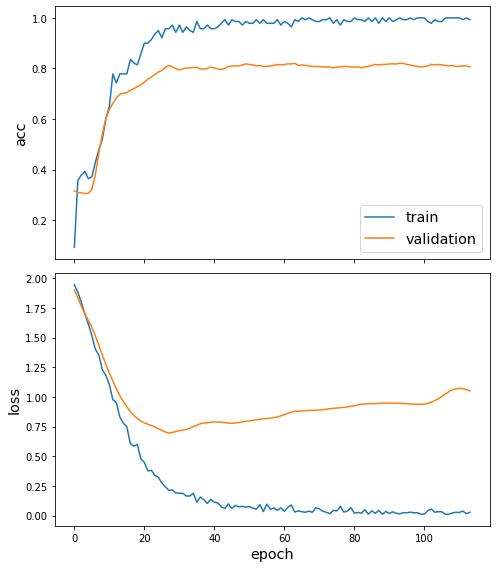

In [19]:
sg.utils.plot_history(history)

#Test the model

In [20]:
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 60ms/step - loss: 1.0494 - acc: 0.7814

Test Set Metrics:
	loss: 1.0494
	acc: 0.7814


#Making prediction with model

In [21]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

1/1 [==============================] - 0s 189ms/step


In [22]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [23]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Theory,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


#Node Embeding

In [24]:
embedding_model = Model(inputs=x_inp, outputs=x_out)
emb = embedding_model.predict(all_gen)
emb.shape

1/1 [==============================] - 0s 218ms/step


(1, 2708, 16)

In [25]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE  # or PCA

In [26]:
X = emb.squeeze(0)
X.shape

(2708, 16)

In [27]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(2708, 2)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

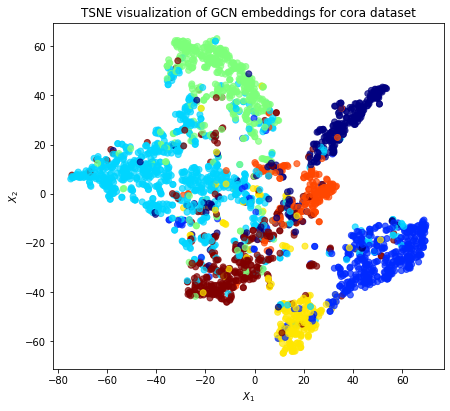

In [28]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)